<a href="https://colab.research.google.com/github/Stellaerranti/NeuralRete/blob/master/Copy_of_Autoencoders_lesson.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Variational autoencoder
Autoencoder - архитектура нейросети, которая сначала с помощью Энкодера сжимает изображение в вектор небольшой размерности(он называется скрытым представлением), а затем восстанавливает этот вектор в исходную картинку. Казалось бы, зачем это нужно? Вход и выход этой нейросети - одна и та-же картинка, ничего нового она не создаёт. Однако практика показывает, что скрытое представление картинки позволяет делать очень интересные и красивые вещи - например, гладкую интерполяцию между 2 написанными от руки цифрами. Более того, Autoencoder можно даже обучить очищать изображения от шума.

Выражаясь математическим языком, Encoder - это функция, которая отображает входное изображение в пространство размерности latent_size, а Decoder - функция, отображающая латентное представление в пространство изображений. 
![alt text](http://fastforwardlabs.github.io/blog-images/miriam/imgs_code/vae.4.png)

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Dense, Dropout, Input, LeakyReLU, Flatten, Reshape
from tensorflow.keras.models import Model,Sequential

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = (x_train / 255.0).astype(np.float32)
x_test = (x_test / 255.0).astype(np.float32)

latent_size = 32
# Create Encoder
def getEncoder(latent_size):
  model = Sequential([
      Dense(units=128, input_dim=(784)),
      LeakyReLU(0.2),
      Dense(units=64),
      LeakyReLU(0.2),
      Dense(units=latent_size, activity_regularizer=tf.keras.regularizers.l1(10e-5))
  ])
  model.compile(loss='binary_crossentropy', optimizer='adam')
  
  return model
# Create Decoder
def getDecoder(latent_size):
  model = Sequential([
    Dense(units=latent_size, input_dim=(latent_size)),    
    LeakyReLU(0.2),
    Dense(units=64),
    LeakyReLU(0.2),
    Dense(units=784),
    
    
  ])
  model.compile(loss='binary_crossentropy', optimizer='adam')
  return model

# Зачем нужна регуляризация?
 В общем и целом, для обучения Autoencoder'a достаточно просто задать loss function как MSE от входного и выходного изображения: выход нейросети должен быть таким же, как вход. Однако в таком случае нейросеть будет пытаться разместить все доступные классы картинок(в нашем случае, цифры из датасета MNIST) как можно дальше друг от друга, и функция будет не определена и разрывна во многих областях латентного пространства, что хорошо видно на первой картинке ниже. Это весьма и весьма плохо: например, нам не удасться погенерировать новые картинки, преобразовывая случайную точку из латентного пространства в случайную картинку - именно из-за того, что функция латентного пространства очень во многих областях разрывна.

 Один из способов решить эту проблему - добавить к loss function небольшое слагаемое, которое будет "стягивать" к нулю все представления картинок в латентом пространстве. Это и есть регуляризация - на картинке слагаемое регуляризации выделено желтым.
 
 ![alt text](https://miro.medium.com/max/240/1*4MlW1d3xszVAGuXiJ1U6Fg.png)
 
 Таким образом, регуляризация играет роль противовеса в loss function Autoencoder'а - она не дает ему просто "разнести" представления картинок в латентом пространстве как можно дальше друг от друга, и заставляет строить геометрически осмысленные представления картинок в латентном пространстве, и в результате функция, отображающая картинки в латентное пространство, становится непрерывной.

![alt text](https://www.jeremyjordan.me/content/images/2018/03/Screen-Shot-2018-03-18-at-7.22.24-PM.png)

# Your autoencoder can also be convolutional

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Dense, Dropout, Input, LeakyReLU, Flatten, Reshape
from tensorflow.keras.models import Model,Sequential

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = (x_train / 255.0).astype(np.float32)
x_test = (x_test / 255.0).astype(np.float32)

x_train = np.expand_dims(x_train, axis=3)
x_test = np.expand_dims(x_test, axis=3)

latent_size = 16
# Create Encoder
def getEncoder(latent_size):
  model = Sequential([
    Conv2D(1,(3,3), activation='sigmoid', padding='same'),
    LeakyReLU(0.2),
    Conv2D(32,(3,3),padding='same'),
    LeakyReLU(0.2),
    #UpSampling2D((2,2)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (3, 3), padding='same'),
    LeakyReLU(0.2),
    Conv2D(64, (3, 3), padding='same'),
    LeakyReLU(0.2),
    #DownSampling2D((2,2)),
    MaxPooling2D(pool_size=(2, 2)),
    Reshape((7*7*64,), input_shape=(7,7,64)),
    Dense(units=7*7*64),
    Dense(units=latent_size, input_dim=latent_size),
    LeakyReLU(0.2)   
  ])
  model.compile(loss='binary_crossentropy', optimizer='adam')
  return model

# Create Decoder
def getDecoder(latent_size):
  model = Sequential([
      Dense(units=latent_size, input_dim=latent_size),
      LeakyReLU(0.2),
      Dense(units=7*7*64),
      Reshape((7, 7, 64), input_shape=(7*7*64,)),
      UpSampling2D((2, 2)),
      Conv2D(64, (3, 3), padding='same'),
      LeakyReLU(0.2),
      Conv2D(64, (3, 3), padding='same'),
      LeakyReLU(0.2),
      UpSampling2D((2, 2)),
      Conv2D(32, (3, 3), padding='same'),
      LeakyReLU(0.2),
      Conv2D(1, (3, 3), activation='sigmoid', padding='same'),
  ])
  model.compile(loss='binary_crossentropy', optimizer='adam')
  
  return model

In [0]:
print(y_train.shape)

(60000,)


In [0]:
# Merge encoder and decoder into the single model
def createVAE(encoder, decoder):
    VAE_input = Input(shape=(28,28,1)) # Set shape to (28, 28, 1) if autoencoder is convolutional, (784, 1) otherwise
    hidden = encoder(VAE_input)
    VAE_output= decoder(hidden)
    VAE = Model(inputs=VAE_input, outputs=VAE_output)
    VAE.compile(loss='mse', optimizer='adam')
    
    return VAE

encoder = getEncoder(latent_size)
decoder = getDecoder(latent_size)
autoencoder = createVAE(encoder, decoder)

Теперь, когда мы написали модель, можно запустить обычное обучение: Input'ами нейросети будут картинки из тренировочного датасета, а label'ами - те-же самые входные картинки.

In [0]:
# Train
autoencoder.fit(x_train, x_train, batch_size=64, epochs=10)

Теперь самое время посмотреть, как наша нейросеть научилась восстанавливать картинки! 

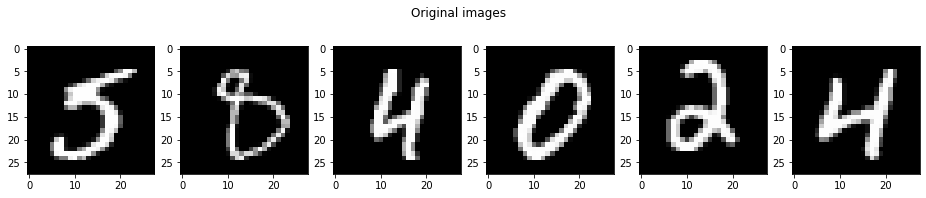

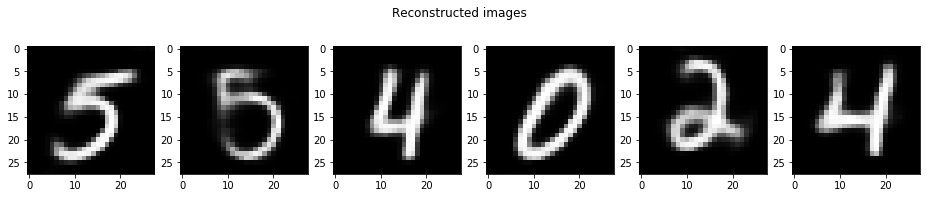

In [0]:
#latent size = 8


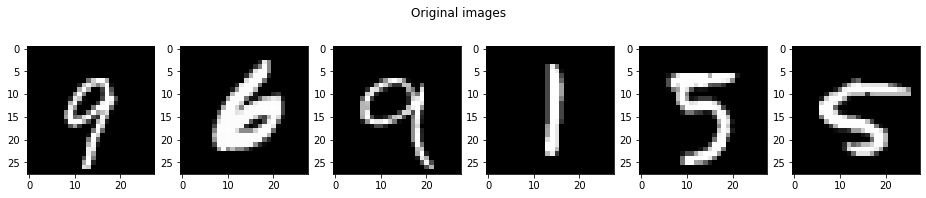

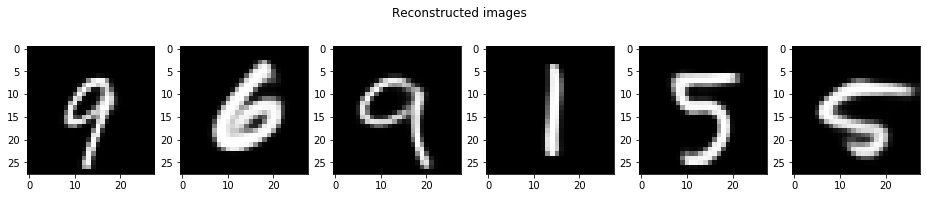

In [0]:
#latent size = 16


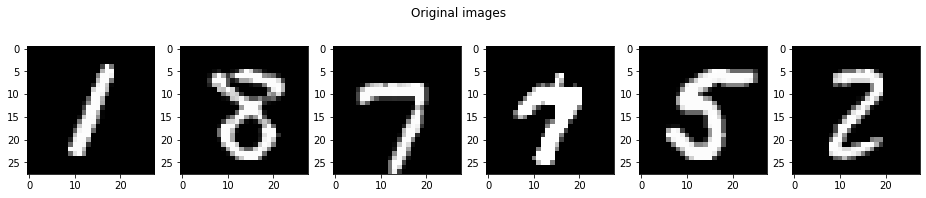

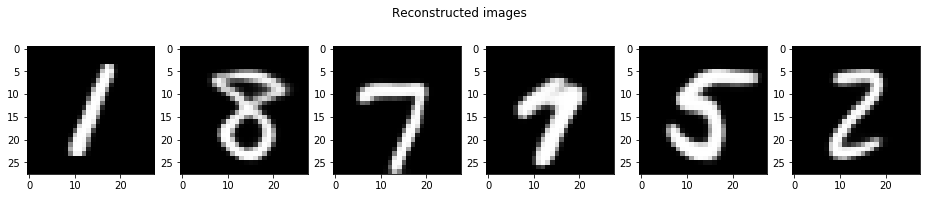

In [0]:
#latent size = 32
from matplotlib import pyplot as plt

def plot_images(images, title):
  fig=plt.figure(figsize=(16, 3))
  columns = images.shape[0]
  rows = 1
  for i in range(columns):
    img = np.random.randint(10, size=(10, 10))
    fig.add_subplot(rows, columns, i+1)
    plt.imshow(images[i], cmap='gray')
  fig.suptitle(title)
  plt.show()  

N_images = 6
samples = x_test[np.random.choice(x_test.shape[0], N_images)]
reconstructed = autoencoder.predict(samples)
plot_images(samples.reshape(-1, 28, 28), title='Original images')
plot_images(reconstructed.reshape(-1, 28, 28), title='Reconstructed images')

# Интерполяция между 2 картинками
Интерполяция - это нахождение промежуточных значений между 2 дискретными величинами. В нашем случае, такой дискретной величиной является картинка.
Латентное представление, которое Autoencoder выучил при обучении, позволяет посмотреть, какие картинки находятся между 2 другими с геометрической точки зрения.

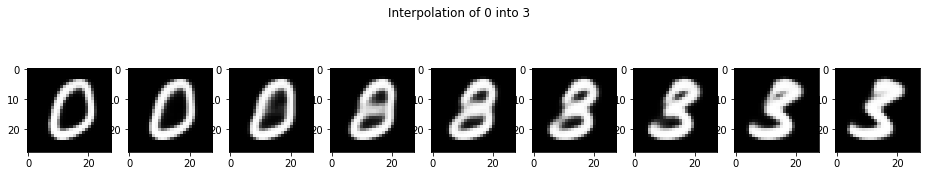

In [0]:
#latent size = 16

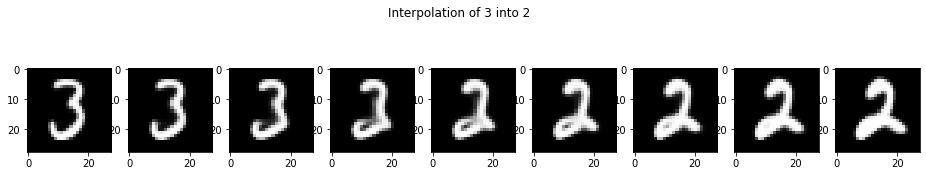

In [0]:
#latent size = 32
def interpolation(vec1, vec2, N_inter):
  intermediate_values = np.zeros((0, vec1.shape[0]))
  for i in range(N_inter):
    intermediate = (1-float(i / N_inter))*vec1 + float(i / N_inter)*vec2
    intermediate_values = np.append(intermediate_values, intermediate.reshape(1, -1), axis=0)
  intermediate_values = np.append(intermediate_values, vec2.reshape(1, -1), axis=0)
  return intermediate_values

N_inter = 8
# Take 2 random images from the test set
choice = np.random.choice(x_test.shape[0], 2)
samples = x_test[choice]
encodings = encoder.predict(samples)

vectors = interpolation(encodings[0], encodings[1], N_inter)
images = decoder.predict(vectors)
plot_images(images.reshape(-1, 28, 28), "Interpolation of %i into %i"%(y_test[choice[0]], y_test[choice[1]]))

Если этот файл запущен не на Google Colab, с помощью этого кода можно создать видео, на котором процесс превращения одной цифры в другую будет виден ещё более наглядно.

In [0]:
import cv2

N_inter = 90
resize_coeff = 10
# Take 2 random images from the test set
choice = np.random.choice(x_test.shape[0], 2)
samples = x_test[choice]
encodings = encoder.predict(samples)

vectors = interpolation(encodings[0], encodings[1], N_inter)
images = decoder.predict(vectors)

size = (images.shape[2]*10, images.shape[1]*10)
out = cv2.VideoWriter('interpolation.avi',cv2.VideoWriter_fourcc(*'DIVX'), 30, size, 0)

for i in range(len(images)):
    img = images[i] / np.max(images[i])
    img = (cv2.resize(255*img.reshape(28, 28), size, cv2.INTER_NEAREST))
    out.write(img.astype(np.uint8))
out.release()

# Denoising
Другое интересное применение Autoencoder'ов - очищение входной картинки от шумов. Такое принципиально возможно из-за того, что размерность латентного пространства очень мала по сравнению с размерностью входного пространства(в нашем случае - 32 и 784 соответственно) - в нём попросту нет места случайному шуму, но зато есть место для общих закономерностей из входного пространства.

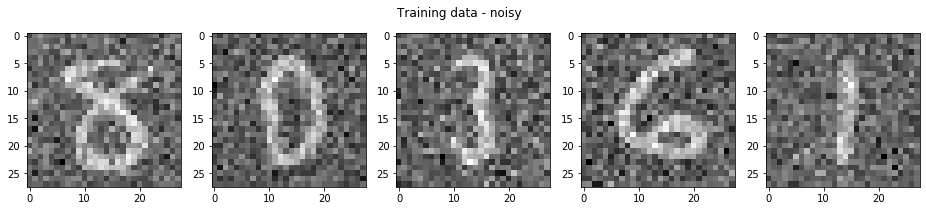

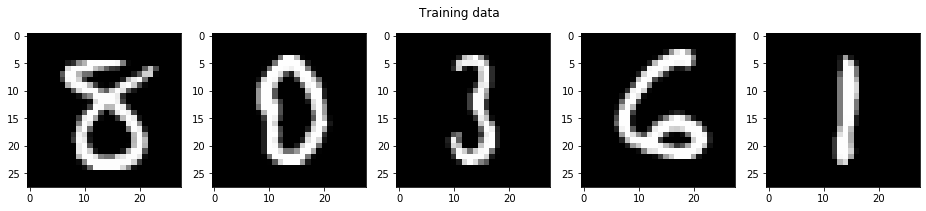

In [0]:
noise_factor = 0.3

# Add some noise to images
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape) 
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape) 
choice = np.random.choice(x_test.shape[0], 5)

# Plot noisy and original images
samples = x_train_noisy[choice]
plot_images(samples.reshape(-1, 28, 28), "Training data - noisy")
plot_images(x_train[choice].reshape(-1, 28, 28), "Training data")

In [0]:
# Training
autoencoder.fit(x_train_noisy, x_train, batch_size=64, epochs=10)

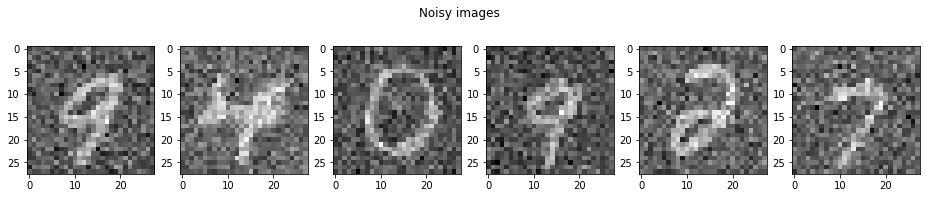

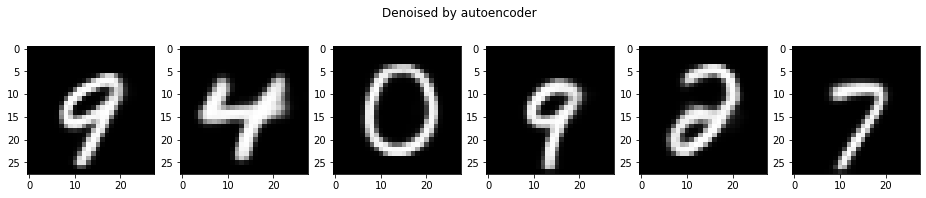

In [0]:
#Latent_size=16
N_images = 6
# Select several images from test dataset
samples = x_test_noisy[np.random.choice(x_test_noisy.shape[0], N_images)]
reconstructed = autoencoder.predict(samples)
# Plot inputs and denoised outputs
plot_images(samples.reshape(-1, 28, 28), title='Noisy images')
plot_images(reconstructed.reshape(-1, 28, 28), title='Denoised by autoencoder')

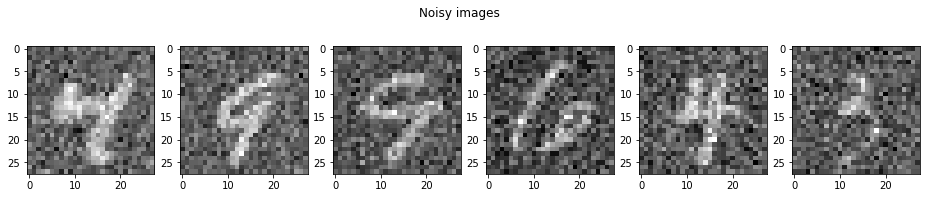

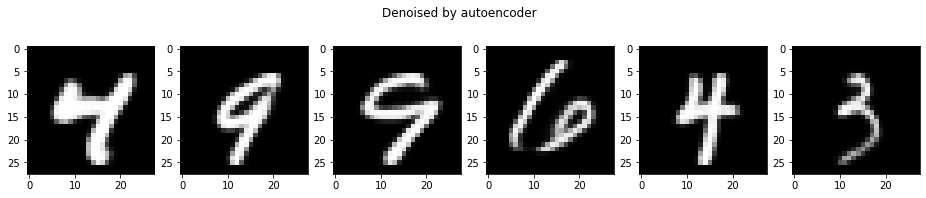

In [0]:
#Latent_size=32
N_images = 6
# Select several images from test dataset
samples = x_test_noisy[np.random.choice(x_test_noisy.shape[0], N_images)]
reconstructed = autoencoder.predict(samples)
# Plot inputs and denoised outputs
plot_images(samples.reshape(-1, 28, 28), title='Noisy images')
plot_images(reconstructed.reshape(-1, 28, 28), title='Denoised by autoencoder')

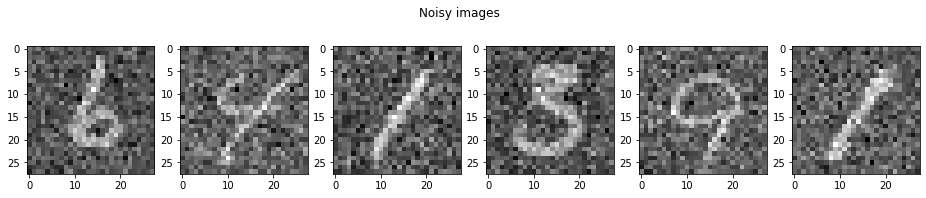

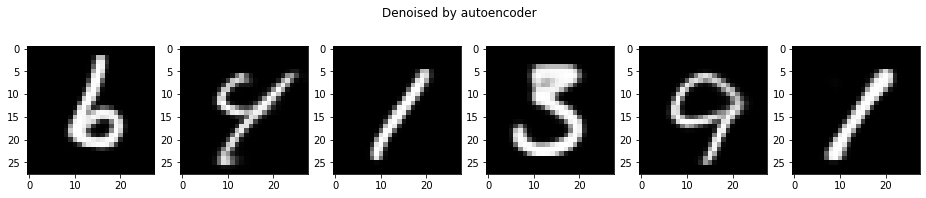

In [0]:
#Latent_size=128
N_images = 6
# Select several images from test dataset
samples = x_test_noisy[np.random.choice(x_test_noisy.shape[0], N_images)]
reconstructed = autoencoder.predict(samples)
# Plot inputs and denoised outputs
plot_images(samples.reshape(-1, 28, 28), title='Noisy images')
plot_images(reconstructed.reshape(-1, 28, 28), title='Denoised by autoencoder')

# Список задач
1) Написать Encoder.

2) Поэкспериментировать с разными размерами латентного пространства - как его размер будет влиять на качество восстановления изображений, на гладкость интерполяции?

3) Попробовать убрать регуляризацию из Encoder'a - изменилось ли качество интерполяции между картинками?